### Assignment 2 image Mosaicing
### Name : Nitin Kandpal, Roll number : 2018802004

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import random

### find the homography matrix 

### DLT way to calculate homography 

In [21]:
## helper function to create n x 9 matrix of points 


In [22]:
def point1_point2_matrix(img_point1, img_point2):
    pointX = [img_point1[0,0],img_point1[0,1],1,0,0,0,
              -img_point2[0,0]*img_point1[0,0],
              -img_point2[0,0]*img_point1[0,1],-img_point2[0,0]]
    pointY = [0,0,0,img_point1[0,0],img_point1[0,1],1,
              -img_point2[0,1]*img_point1[0,0],
              -img_point2[0,1]*img_point1[0,1],-img_point2[0,1]]
    return pointX,pointY

In [23]:
def DLT_homography(img1_points,img2_points):
    #M = np.empty((2*img_points.shape[0], 12),dtype='int64')
    A = []
    count = 0
    for img1_point,img2_point in zip(img1_points,img2_points):
        pointX,pointY = point1_point2_matrix(img1_point,img2_point)
        #print(pointX,pointY)
        ## 2x9 matr
        #np.append(M,np.array(A_point),axis=0)
        A.append(pointX)
        A.append(pointY)
    A = np.array(A)
    ### perfomr SVD
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    ## use the last value
    M = np.transpose(vh)
    M_1d = M[:,-1]
    M_1d = M_1d/M_1d[-1]
    M_2d = np.reshape(M_1d,[3,3])
    return M_2d

###  Ransac variation to calculate optimal Homography matrix

#### Helper function to calcuate Homograpgy projection error 

In [24]:
def reprojection_error(img1_points,img2_points,P):
    error = 0
    for img1_point, img2_point in zip(img1_points,img2_points):
        h_img1_point = np.array([img1_point[0,0],img1_point[0,1],1])
        predicted_img_point = np.dot(P,h_img1_point)
        X = int(round(predicted_img_point[0]/predicted_img_point[2]))
        Y = int(round(predicted_img_point[1]/predicted_img_point[2]))
        temp_error = np.linalg.norm(img2_point-np.array([X,Y]))
        #print(temp_error)
        error = temp_error + error
    return error
    #return temp_error

In [25]:
#reprojection_error(src,dst,H)

In [26]:
def ransac_variation_homography(img1_points,img2_points):
## select random points
    count =0
    temp = 1000000
    
    while(count<100):
        index = random.sample(range(len(img1_points)), 4)
        random_img1_points = img1_points[index,:]
        random_img2_points = img2_points[index,:]
        M1 = DLT_homography(random_img1_points,random_img2_points)
        r_error = reprojection_error(img1_points,img2_points,M1)
        #print(index, r_error)
        count=count+1
        if(r_error < temp):
            temp = r_error
            M = M1

    return M

In [28]:
def crop_function(img):
    
    
    [height,width,channel] = img.shape
    
    w = width
    
    h = height
    temp1 = np.zeros((height,4,3))
    temp2 = np.zeros((4,width,3))
    for col in range(width-5):
        if(np.array_equal(img[:,col:col+4,:],temp1)):
            
            w = col
            break
    for row in range(height-5):
        
        if(np.array_equal(img[row:row+4,:,:],temp2)):
            h = row 
            break
    #print(h)        
    img1 = img[0:h,0:w]
    #print (w)
    return img1
        
        

### stitching the image together 

image_mosaicing function takes two images and perfrom the image mosaicing and return panoroma image

In [29]:
def image_mosaicing(img_1,img_2):

    img2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2GRAY)

    img1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)

    #find the shift point

    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)


    ## match the points 
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)


    # select the good points
    selected_match = []
    number_of_good_point=0
    for match in matches:
        if match[0].distance < 0.5*match[1].distance:
            selected_match.append(match)
            number_of_good_point = number_of_good_point+1
    matches = np.asarray(selected_match)
        #if len(matches[:,0]) >= 4:
    ## check if number of good matched points are greater or equal to 4    
    if number_of_good_point >= 4:
        src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
        ## calculate the homography    
        H = ransac_variation_homography(src,dst)
        #H = DLT_homography(src,dst) 
        
        ## perform the image warping 
        # warp the image1 in with homograply 
        dst_img = cv2.warpPerspective(img_1,H,(img_2.shape[1] + img_1.shape[1], img_2.shape[0]+img_1.shape[0]))
        
        #assign img2 to warp image for only valid pixels
        for i in range(img_2.shape[0]):
            for j in range(img_2.shape[1]):
                
                if((img_2[i,j,0]!= 0) & (img_2[i,j,1]!= 0) & (img_2[i,j,2]!= 0)):
                    
                    dst_img[i,j] = img_2[i,j]
                    
        
        ## crop the image for valid pixels 
        dst1_img = crop_function(dst_img)
        
        #cv2.imwrite('test_images/output.jpg',dst1_img)
        plt.imshow(cv2.cvtColor(dst1_img,cv2.COLOR_BGR2RGB))
        plt.show()
        return dst1_img
    else:
        print ("no proper matches found")
        return None



In [ ]:
## check the image_mosaicing function

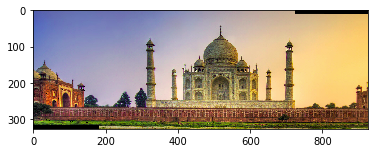

In [30]:
img_1 = cv2.imread('test_images/img2_2.png')
img_2 = cv2.imread('test_images/img2_1.png')

dst = image_mosaicing(img_1,img_2)

## main function to stitch multiple images 

The function accept the path folder where sequence of images are stored.
It uses the avove image_mosaicing function which stiches two images to perform the stitch multiple images  

In [31]:
def stich_multiple_images(path):
    
    images = glob.glob(path)

    count =0
    for fname in sorted(images):
        img_1 = cv2.imread(fname)

        if(count < 1):
            img_2 = img_1.copy()
        else:

            img_2 = image_mosaicing(img_1,img_2)    
        count = count+1

    #plt.imshow(img_2)
    #plt.show()    
    
    
    

## results on test images 

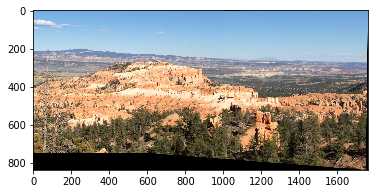

In [32]:
import glob
path = 'test_images1/*png'
stich_multiple_images(path)

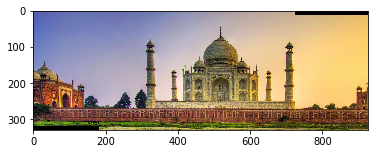

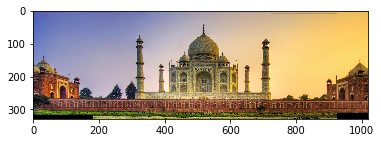

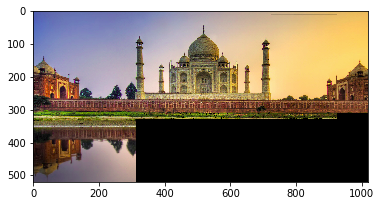

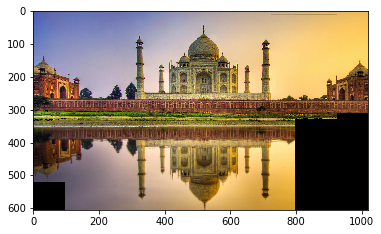

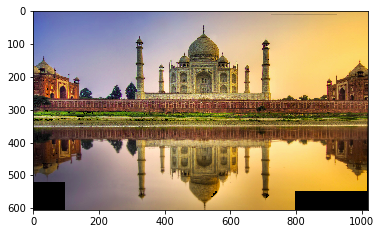

In [33]:
path = 'test_images2/*png'
stich_multiple_images(path)

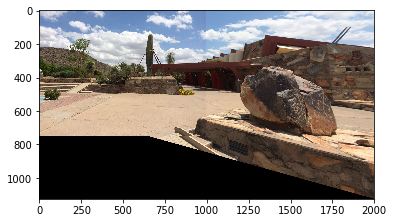

In [34]:
path = 'test_images3/*png'
stich_multiple_images(path)

In [16]:
path = 'test_images4/*jpg'
stich_multiple_images(path)

no proper matches found


## result on own image 

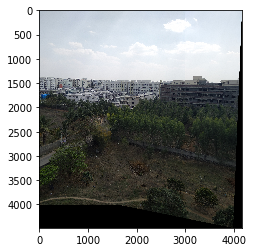

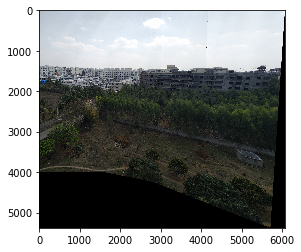

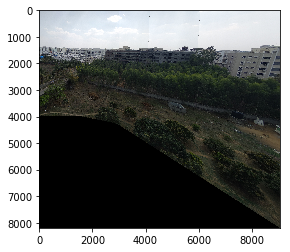

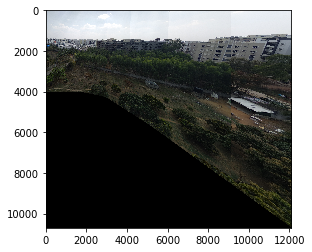

In [35]:
path = 'own_images/*jpg'
stich_multiple_images(path)